In [2]:
%run classes.ipynb

In [8]:
%run classes.ipynb
# Training cell
import numpy as np
from sklearn.model_selection import train_test_split

emptyRatio = 47
objectwidth = 83
objectheight = 122
layers = 187

odtype = 'scatter'
neighbourhoodDistance = 3
porositythreshold = 0.5
neighbourhoodZ = 1
windowSize = layers // 3
windowOffset = layers // 3
noOfBins = 20
n_neighbors = 3
test_size = 0.4
hsegments = [0,26,50,74,98,122]
mask = np.zeros((objectwidth, objectheight))

allImages = readRawTreeImages()
allImages = allImages[(np.arange(len(allImages))!=20) & (np.arange(len(allImages))!=27)]
X_test = allImages[:, -layers//3:]
X_train = allImages[:, :-layers//3]

labels = getLabels(porositythreshold)
print(len(labels))
Y_train = np.tile(labels, 2)
Y_test = np.tile(labels, 1)

# Todo: Uncomment this line
mask = makeMask(X_train, emptyRatio)

bgr = backgroundRemover(mask)
ab = blockAccumulator(windowSize, windowOffset)
oc1 = outlierCalculator(odtype, neighbourhoodDistance, neighbourhoodZ)
# a1 = accumulator(windowSize, windowOffset)

allTrainingHists = []

def makesegments(image, hsegments):
    segments = []
    for obimg in image:
        for i in range(len(hsegments)-1):
            segments.append(obimg[hsegments[i]:hsegments[i+1],:])
    return segments

trainObjects = np.moveaxis(X_train, 1, 0)
testObjects = np.moveaxis(X_test, 1, 0)

allOcvals = []
allPresValues = []
i = 0
for image in trainObjects:
    # Ta bilden, omvandla till en array av bilder (en bild per obj)
    # Vilken struktur behöver preprocess? Lista med numpy array
    # image är 26x122x83
    # segments ska vara (26*5)x122x83
    i +=1 
    noback = bgr.removeBackground(image)
    segments = makesegments(noback, hsegments)
    segmentblocks = ab.next(segments)
    if(segmentblocks is False):
        continue
    # plt.hist(trainoutliers[0][1].flatten(), bins=bincount, range=(minval, maxval))
    ocvals = oc1.calculate(segmentblocks)
    allOcvals.append(ocvals)
    # if(i == 0 or i == 1 or i == 2):
    #     plt.imshow(pres[0])
    #     plt.figure()
    #     plt.hist(pres[0].flatten())
    #     plt.yscale('log')
    #     plt.figure()
    # ocVals: List[layers][objects][matrix]
ocmin = np.nanmin(np.concatenate([np.concatenate([o.flatten() for o in oo]) for oo in allOcvals]))
ocmax = np.nanmax(np.concatenate([np.concatenate([o.flatten() for o in oo]) for oo in allOcvals]))
e1 = encoder(noOfBins, ocmin, ocmax)

for ocvals in allOcvals:
    if len(ocvals) > 0:
        # Print a chart here
        hists = e1.encode(ocvals)
        for acc in hists:
            allTrainingHists.append(acc)

130


In [9]:
(ocmin, ocmax)

(-10261.60344670157, 8271.572368553752)

In [10]:
repetitions = len(allTrainingHists) / len(Y_train)
knn = neighbors.KNeighborsClassifier(n_neighbors, weights="uniform", n_jobs=-1)
scaler = StandardScaler()
clf = Pipeline([('scaler', scaler), ('classifier', knn)])
ytrain2 = np.tile(Y_train.astype('int'), [np.int32(repetitions)])
clf.fit(allTrainingHists, ytrain2)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', KNeighborsClassifier(n_jobs=-1, n_neighbors=3))])

0.9800273130761352


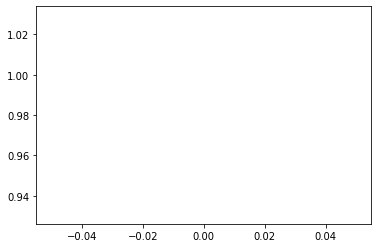

In [13]:
# Testing cell
from sklearn.metrics import f1_score, roc_auc_score
oc1.reset()
y_test = Y_test.astype('int')

testx = []
predictions = []
letsPrint = False
for image in testObjects:
    # Start of timing
    # Put our actual pipeline here 🥳
    # Remove background
    # Create segments
    # Accumulate
    # calculate outliers
    # create histograms
    # classify
    noback = bgr.removeBackground(image)
    segments = makesegments(noback, hsegments)
    segmentblocks = ab.next(segments)
    if(segmentblocks is False):
        continue
    ocvals = oc1.calculate(segmentblocks)
    hists = e1.encode(ocvals)
    pred = clf.predict_proba(hists)[:,1]
    # End of timing
    testx.append(hists)
    predictions.append(pred)
    if len(ocvals) > 0:
        if(letsPrint):
            plt.imshow(image[0])
            plt.title("background 0")
            plt.figure()
            plt.imshow(image[1])
            plt.title("background 1")
            plt.figure()
            plt.imshow(noback[0])
            plt.title("nobackground 0")
            plt.figure()
            plt.imshow(noback[1])
            plt.title("nobackground 1")
            plt.figure()
            plt.imshow(pres[0])
            plt.title("pres 0")
            plt.figure()
            plt.imshow(pres[1])
            plt.title("pres 1")
            plt.figure()
            plt.imshow(ocvals[0])
            plt.title("ocvals 0")
            plt.figure()
            plt.imshow(ocvals[1])
            plt.title("ocvals 1")
            plt.figure()
            plt.hist(ocvals[0].flatten(), bins=noOfBins, range=(ocmin, ocmax))
            plt.yscale('log')
            plt.figure()
            plt.hist(ocvals[1].flatten(), bins=noOfBins, range=(ocmin, ocmax))
            plt.yscale('log')
            plt.figure()
            break

# investigate accuracy etc here. Potentially batch it based on layer
ysvalue = []
for index, o in enumerate(predictions):
    print(roc_auc_score(y_test, o))
    ysvalue.append(roc_auc_score(y_test, o))
plt.plot(np.arange(0, len(ysvalue)), ysvalue)

In [55]:
print(predictions)

[array([0.33333333, 0.        , 0.33333333, 0.        , 0.33333333,
       0.        , 0.33333333, 0.33333333, 0.        , 0.        ,
       0.        ]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0.        , 0.        , 0.        , 0.        , 0.33333333,
       0.        , 0.        , 0.33333333, 0.        , 0.        ,
       0.        ]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0.        , 0.        , 0.        , 0.        , 0.33333333,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        ]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), arra

: 